In [28]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from modules.training_and_fine_tuning.training.train_cnn_model_using_mel_spectrogram import CnnModelUsingMelSpectrogram
from modules.training_and_fine_tuning.utils.mel_spectrogram_image_data_utils import MelSpectrogramDataUtils
from config.vi_config import VietnameseDatasetConfig
from modules.training_and_fine_tuning.utils.model_utils import ModelUtilities

In [29]:
def get_n_mels_paths(n_mels, Config):
    train_path = Config.n_mels_config[n_mels].train_path
    validation_path = Config.n_mels_config[n_mels].validation_path
    test_path = Config.n_mels_config[n_mels].test_path
    return train_path, validation_path, test_path

In [30]:
def get_train_test_val_data(n_mels, Config):
    train_path, test_path, val_path = get_n_mels_paths(n_mels, Config)
    X_train, y_train = MelSpectrogramDataUtils.process_data(train_path)
    X_val, y_val = MelSpectrogramDataUtils.process_data(val_path)
    X_test, y_test = MelSpectrogramDataUtils.process_data(test_path)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [31]:
n_mels = 512

In [32]:
train_file_path, test_file_path, val_file_path = get_n_mels_paths(n_mels, VietnameseDatasetConfig)
print(train_file_path, test_file_path, val_file_path)

D:/data_analysis/speech_emotion_recognition/data/VietnameseDataset/train_test_splited_data/images/512/train.csv D:/data_analysis/speech_emotion_recognition/data/VietnameseDataset/train_test_splited_data/images/512/validation.csv D:/data_analysis/speech_emotion_recognition/data/VietnameseDataset/train_test_splited_data/images/512/test.csv


In [33]:
X_train, y_train, X_val, y_val, X_test, y_test = get_train_test_val_data(n_mels, VietnameseDatasetConfig)

In [34]:
cnn_model_mel_spectrograms = ModelUtilities.load_model(f'cnn_model_using_mel_spectrogram_with_{n_mels}_n_mels.keras')

In [35]:
num_layers_to_unfreeze = 4
for layer in cnn_model_mel_spectrograms.layers[-num_layers_to_unfreeze:]:
    layer.trainable = True

In [36]:
cnn_model_mel_spectrograms.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
cnn_model_mel_spectrograms.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model_checkpoint = ModelCheckpoint('fine_tuned_model_using_mel_spectrograms.keras', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=7, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=1, factor=0.5, min_lr=1e-6)

history = cnn_model_mel_spectrograms.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=64, callbacks=[model_checkpoint, early_stop, lr_reduction])

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.2544 - loss: 3.8062 - val_accuracy: 0.3388 - val_loss: 2.4054 - learning_rate: 2.0000e-04
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.3151 - loss: 2.1893 - val_accuracy: 0.4098 - val_loss: 1.9410 - learning_rate: 2.0000e-04
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.3447 - loss: 1.8131 - val_accuracy: 0.4372 - val_loss: 1.8058 - learning_rate: 2.0000e-04
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.3695 - loss: 1.5911 - val_accuracy: 0.4699 - val_loss: 1.7437 - learning_rate: 2.0000e-04
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.4009 - loss: 1.6877 - val_accuracy: 0.4809 - val_loss: 1.6955 - learning_rate: 2.0000e-04
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.4389 - loss: 1.5122 - val_accuracy: 0.4973 - val_loss: 1.6674 - learning_rate: 2.0000e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - acc

In [39]:
loss, accuracy = cnn_model_mel_spectrograms.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7018 - loss: 0.9840
Test Loss: 1.070434808731079, Test Accuracy: 0.6478873491287231


In [40]:
history_dict = history.history
print(history_dict)

{'accuracy': [0.2971751391887665, 0.35141241550445557, 0.3672316372394562, 0.3785310685634613, 0.4045197665691376, 0.44632768630981445, 0.4677966237068176, 0.49604520201683044, 0.5107344388961792, 0.5129943490028381, 0.5548022389411926, 0.5446327924728394, 0.5717514157295227, 0.5728813409805298, 0.5830508470535278, 0.5694915056228638, 0.5796610116958618, 0.6350282430648804, 0.6553672552108765, 0.6350282430648804, 0.6327683329582214, 0.6632768511772156, 0.6666666865348816, 0.6632768511772156, 0.710734486579895, 0.710734486579895, 0.7152542471885681, 0.7175140976905823, 0.7220339179039001, 0.7310734391212463, 0.7570621371269226, 0.7446327805519104], 'loss': [3.259760856628418, 2.0394246578216553, 1.7756956815719604, 1.6132917404174805, 1.648309350013733, 1.4890094995498657, 1.4918148517608643, 1.3791126012802124, 1.4059971570968628, 1.29795503616333, 1.2607483863830566, 1.2557729482650757, 1.21621572971344, 1.1822493076324463, 1.1474941968917847, 1.152953863143921, 1.1068562269210815, 1.

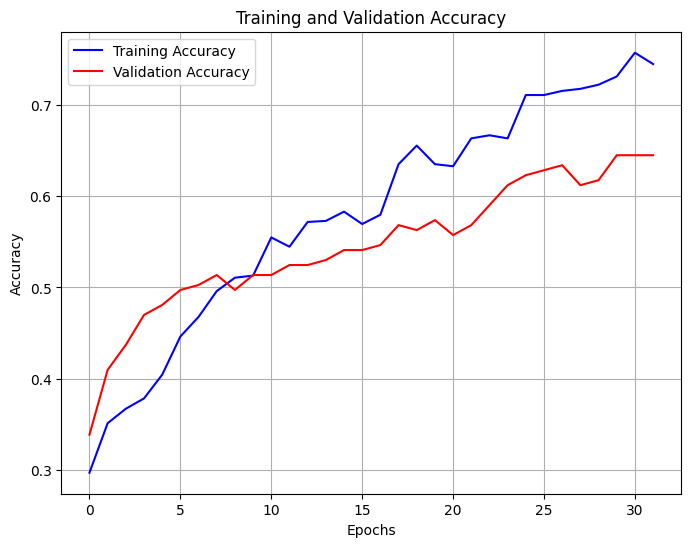

In [41]:
ModelUtilities.plot_training_history(history_dict)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


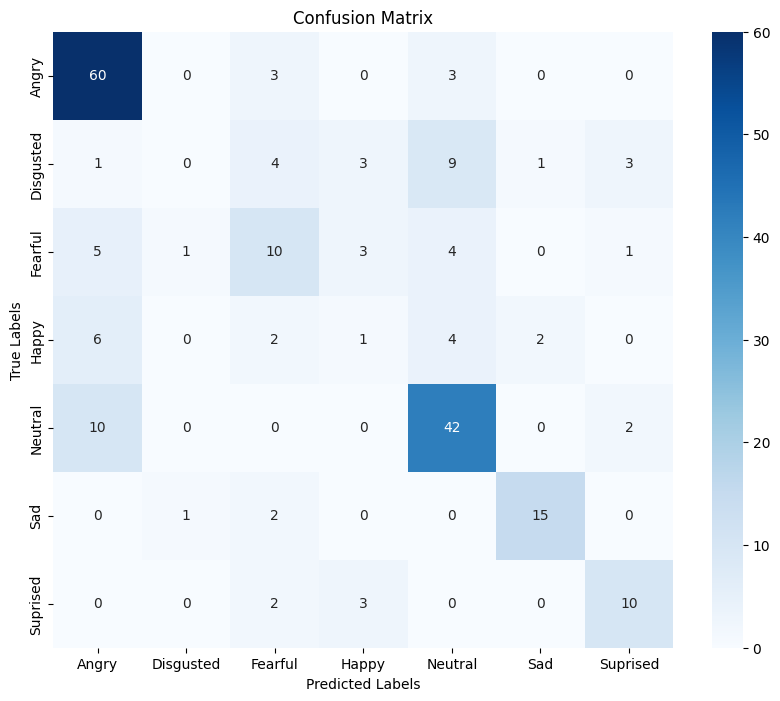

In [42]:
ModelUtilities.plot_confusion_matrix(cnn_model_mel_spectrograms, X_test, y_test, ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Suprised'])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


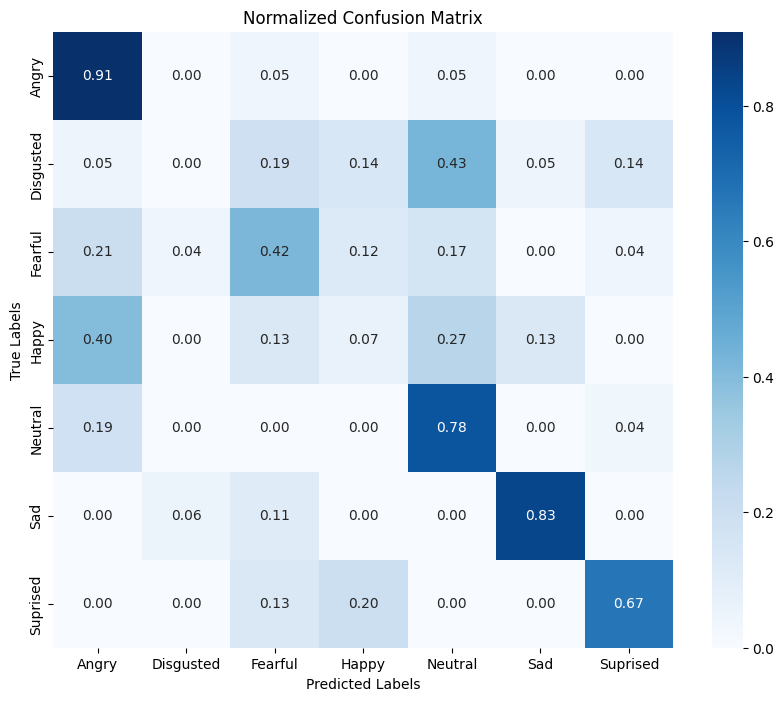

In [43]:
ModelUtilities.plot_confusion_matrix_normalized(cnn_model_mel_spectrograms, X_test, y_test, ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Suprised'])